In [1]:
import numpy as np
import sys
import joblib
import matplotlib.pyplot as plt
from transformer_lens.components import TransformerBlock
import ridge_utils.npp
from ridge_utils.util import make_delayed
from ridge_utils.dsutils import make_word_ds
from ridge_utils.DataSequence import DataSequence
import warnings
from configs import engram_dir
import os
from datasets import load_dataset
from transformer_lens import HookedTransformer
from sae_lens import SAE
import torch

from transformer_lens.utils import tokenize_and_concatenate
from huggingface_hub import login
from configs import huggingface_token

login(token=huggingface_token)
device = "cuda" if torch.cuda.is_available() else "cpu"

box_dir = os.path.join(engram_dir, 'huth_box/')
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Some parameters
trim_start = 50 # Trim 50 TRs off the start of the story
trim_end = 5 # Trim 5 off the back
ndelays = 4 # We use 4 FIR delays (2 seconds, 4 seconds, 6 seconds, 8 seconds)
delays = range(1, ndelays + 1)

In [2]:
grids = joblib.load(os.path.join(box_dir, "grids_huge.jbl")) # Load TextGrids containing story annotations
trfiles = joblib.load(os.path.join(box_dir, "trfiles_huge.jbl")) # Load TRFiles containing TR information

In [3]:
wordseqs = make_word_ds(grids, trfiles)
for story in wordseqs.keys():
    wordseqs[story].data = [i.strip() for i in wordseqs[story].data]
print("Loaded text data")

Loaded text data


# Explore Participant Responses

In [4]:
response_path = os.path.join(box_dir, 'responses', 'full_responses', 'UTS03_responses.jbl')
resp_dict = joblib.load(response_path)
to_pop = [x for x in resp_dict.keys() if 'canplanetearthfeedtenbillionpeoplepart' in x]
for story in to_pop:
    del resp_dict[story]
train_stories = list(resp_dict.keys())
train_stories = [t for t in train_stories if t != "wheretheressmoke"]
test_stories = ["wheretheressmoke"]
print("Loaded participant responses")


Loaded participant responses


# Load LLM

In [5]:
model = HookedTransformer.from_pretrained("gemma-2-2b", device=device)
tokenizer = model.tokenizer

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model gemma-2-2b into HookedTransformer


In [6]:
def override_to_local_attn(model, window_size=512):
    for b in model.blocks:  # Possibly a cleaner way by correctly using 'use_local_attn'
        if isinstance(b, TransformerBlock):
            n_ctx = b.attn.cfg.n_ctx
            attn_mask = torch.zeros((n_ctx, n_ctx)).bool()
            for i in range(n_ctx):
                start_idx = max(0, i-window_size)
                attn_mask[i, start_idx:i+1] = True
            b.attn.mask = attn_mask.to(device)

override_to_local_attn(model)

In [7]:
def find_word_boundaries(text_data, tokenizer):
    full_story = " ".join(text_data).strip()
    tokenized_story = tokenizer(full_story)['input_ids']

    word_boundaries = []  # In the tokenized story
    curr_word_idx = 0
    curr_word = text_data[curr_word_idx]
    curr_token_set = []

    if curr_word == '':
        curr_word_idx += 1
        curr_word = text_data[curr_word_idx]
        word_boundaries.append(1)

    for token_idx, token in enumerate(tokenized_story):
        curr_token_set.append(token)
        detokenized_chunk = tokenizer.decode(curr_token_set)
        if curr_word in detokenized_chunk:
            word_boundaries.append(token_idx)
            curr_word_idx += 1
            if curr_word_idx == len(text_data):
                break
            curr_word = text_data[curr_word_idx]
            curr_token_set = []

            if curr_word == '':  # Edge case
                word_boundaries.append(token_idx)
                curr_word_idx += 1
                if curr_word_idx == len(text_data):
                    break
                curr_word = text_data[curr_word_idx]

    return tokenized_story, word_boundaries


In [16]:
def get_sparsity(layer):
    release = "gemma-scope-2b-pt-res-canonical"
    sae_id = f"layer_{layer}/width_16k/canonical"
    sae = SAE.from_pretrained(release, sae_id)[0].to(device)

    aggregate_l0 = None #np.zeros(16384)
    aggregate_l1 = None #np.zeros(16384)
    total_samples = 0
    for train_story in train_stories:
        ws = wordseqs[train_story]
        text_data = ws.data
        tokenized_story, word_boundaries = find_word_boundaries(text_data, tokenizer)
        hook_key = f'blocks.{layer}.hook_resid_post'
        with torch.no_grad():
            _, cache = model.run_with_cache(
                torch.tensor(tokenized_story).to(device),
                prepend_bos=True,
                names_filter=lambda name: name==hook_key,
            )
        llm_response = cache[hook_key][0, word_boundaries, :]
        with torch.no_grad():
            feature_acts = sae.encode(llm_response)
        n_samples, n_features = feature_acts.shape
        #dead_features = torch.argwhere(feature_acts.sum(axis=0)==0).cpu().numpy().flatten()
        l0 = (torch.abs(feature_acts)>0).sum(axis=0).cpu().numpy()
        l1 = torch.abs(feature_acts).sum(axis=0).cpu().numpy()
        if aggregate_l0 is None:
            aggregate_l0 = np.zeros(n_features)
            aggregate_l1 = np.zeros(n_features)
        aggregate_l0 += l0
        aggregate_l1 += l1
        total_samples += n_samples
    print(total_samples)
    return aggregate_l0 / total_samples, aggregate_l1 / total_samples

In [17]:
l0, l1 = get_sparsity(12)

181737


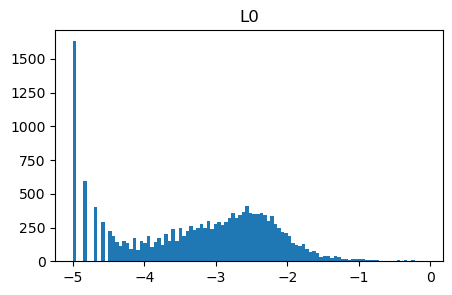

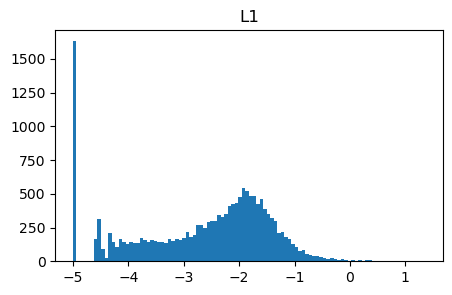

In [20]:
plt.figure(figsize=(5,3))
plt.hist(np.log10(l0+1e-5), bins=100)
plt.title("L0")
plt.show()
plt.figure(figsize=(5,3))
plt.hist(np.log10(l1+1e-5), bins=100)
plt.title("L1")
plt.show()